In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, r2_score

In [2]:
data = pd.read_csv('C:/Users/geeth/Downloads/Bengaluru_House_Data.csv')

area_type          0
availability       0
location           1
size              16
society         5502
total_sqft         0
bath              73
balcony          609
price              0
dtype: int64
area_type        object
availability     object
location         object
size             object
society          object
total_sqft       object
bath            float64
balcony         float64
price           float64
dtype: object
               bath       balcony         price
count  13247.000000  12711.000000  13320.000000
mean       2.692610      1.584376    112.565627
std        1.341458      0.817263    148.971674
min        1.000000      0.000000      8.000000
25%        2.000000      1.000000     50.000000
50%        2.000000      2.000000     72.000000
75%        3.000000      2.000000    120.000000
max       40.000000      3.000000   3600.000000


C:\Users\geeth\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\geeth\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\geeth\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


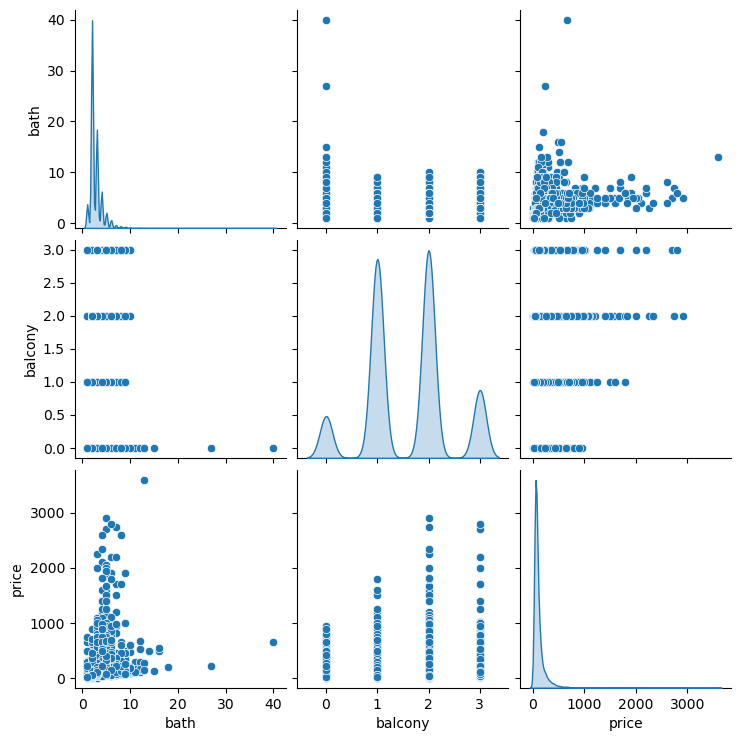

In [3]:
# Check for missing values
print(data.isnull().sum())

# Check data types
print(data.dtypes)

# Check basic statistics
print(data.describe())

# Visualize the data using pairplot
sns.pairplot(data, diag_kind='kde')
plt.show()

In [11]:
data[~pd.to_numeric(data['price'], errors='coerce').notna()]

,area_type,availability,location,size,society,total_sqft,bath,balcony,price


In [15]:
data.dropna(subset=['price'], inplace=True)

In [20]:
# Convert 'total_sqft' column to numeric after processing the string
def process_sqft_string(sqft_str):
    try:
        tokens = sqft_str.split('-')
        if len(tokens) == 2:
            return (float(tokens[0]) + float(tokens[1])) / 2
        return float(sqft_str)
    except ValueError:
        return np.nan

data['total_sqft'] = data['total_sqft'].apply(process_sqft_string)
data.dropna(subset=['total_sqft'], inplace=True)  # Drop rows with NaN values after conversion


In [21]:
# Convert 'price' and 'total_sqft' columns to float
data['price'] = data['price'].astype(float)
data['total_sqft'] = data['total_sqft'].astype(float)

# Calculate price per square foot
data['price_per_sqft'] = data['price'] / data['total_sqft']

# Create total_sqft_per_price feature
data['total_sqft_per_price'] = data['total_sqft'] * data['price_per_sqft']


In [23]:

# Create a new feature: total_sqft_per_price
data['total_sqft_per_price'] = data['total_sqft'] / data['price']



In [24]:
# Create a new feature: area_type_factor
data['area_type_factor'] = 1.0
data.loc[data['area_type'] == 'Villa', 'area_type_factor'] = 1.2
data.loc[data['area_type'] == 'Row House', 'area_type_factor'] = 1.1



In [25]:
# Create a new feature: society_factor
data['society_factor'] = 1.0
data.loc[data['society'] == 'Emaar Palm Gardens', 'society_factor'] = 1.15
data.loc[data['society'] == 'Prestige White Meadows', 'society_factor'] = 1.1
data.loc[data['society'] == 'Mantri Webcity', 'society_factor'] = 1.05


In [26]:

# Drop unnecessary columns
data.drop(['price', 'area_type', 'society'], axis=1, inplace=True)


In [27]:

# Split the data into features (X) and target (y)
X = data.drop('total_sqft_per_price', axis=1)
y = data['total_sqft_per_price']



In [28]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)




In [32]:
# Drop the 'availability' column
X_train.drop('availability', axis=1, inplace=True)
X_test.drop('availability', axis=1, inplace=True)


In [34]:
# Drop the 'location' column
X_train.drop('location', axis=1, inplace=True)
X_test.drop('location', axis=1, inplace=True)


In [36]:
import re

# Extract numeric part of the 'size' column
X_train['size_numeric'] = X_train['size'].apply(lambda x: re.findall(r'\d+', x)[0] if isinstance(x, str) else x).astype(float)
X_test['size_numeric'] = X_test['size'].apply(lambda x: re.findall(r'\d+', x)[0] if isinstance(x, str) else x).astype(float)

# Drop the original 'size' column
X_train.drop('size', axis=1, inplace=True)
X_test.drop('size', axis=1, inplace=True)


In [37]:
# Scale the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)



In [38]:
# Create the SVM regressor
svm_regressor = SVR(kernel='rbf', C=1, epsilon=0.2, gamma='scale')



In [43]:
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.svm import SVR

# Create a pipeline with an imputer and SVR
pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),  # You can use other strategies like 'median' or 'most_frequent' based on your data
    ('scaler', StandardScaler()),
    ('svm_regressor', SVR(kernel='rbf', C=1, epsilon=0.2, gamma='scale'))
])

# Fit the pipeline on the training data
pipeline.fit(X_train, y_train)

# Make predictions
y_pred = pipeline.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Mean Squared Error: ", mse)
print("R-squared: ", r2)

Mean Squared Error:  36.215341798076395
R-squared:  0.388889097109849
